In [1]:
#%matplotlib widget 
import sys
import numpy as np
import mpi4py
import os

from pyDFCSR_2D import CSR2D
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py

from pyDFCSR_2D.tools import plot_surface

import pickle
import os
import re
import shutil

[nid200000:1191589] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.nid200000.104522/jf.0/2706505728/shared_mem_cuda_pool.nid200000 could be created.
[nid200000:1191589] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
def replace_config_content(config_path, keyword, replacement_string):
    """
    Replace content after 'keyword:' in the line starting with keyword: in the given file.

    Args:
    - filepath (str): Path to the text file.
    - replacement_string (str): String to replace the content after 'beamfile:'.

    Returns:
    - bool: True if the replacement was successful, False otherwise.
    """
    filepath = config_path;
    try:
        # Read the file line by line
        with open(filepath, 'r') as file:
            lines = file.readlines()

        # Define the keyword to search for
        keyword = '  ' + keyword;

        # Iterate through the lines
        for i, line in enumerate(lines):
            if line.startswith(keyword):
                # Find the position of 'beamfile:'
                index = line.find(keyword)
                
                # Replace everything after 'beamfile:' with replacement_string
                lines[i] = line[:index + len(keyword)] + ' ' + replacement_string + '\n'  # Include newline if needed
                break  # Assuming only one line starts with '  beamfile:'

        # Write the modified lines back to the file
        with open(filepath, 'w') as file:
            file.writelines(lines)

        return True  # Return True if successful

    except Exception as e:
        print(f"Error occurred: {e}")
        return False  # Return False if there was an error

In [3]:
lattice_names = ['b1le_0', 'b1le_1',
                 'b2le_0', 'b2le_1',
                 'b3le_0', 'b3le_1',
                 
                 'b3re_0', 'b3re_1',
                 'b2re_0', 'b2re_1',
                 'b1re_0', 'b1re_1',
                 
                 'FF_line_full_lattice', 'EXPT_to_IP_lattice'
                ]

In [39]:
input_dir = '/global/homes/o/ocamacho/pydfCSR_sims/beam_files/';
phi1 = '-17.0'; phi2 = '-41.5'
init_beam = input_dir + 'BEGBC20_1M_-17.0-41.5.h5'
init_config = r'/global/homes/o/ocamacho/pydfCSR_sims/config_files/W_chicane_config_base.yaml';
output_dir =  '/global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/'

In [5]:
init_config

'/global/homes/o/ocamacho/pydfCSR_sims/config_files/W_chicane_config_base.yaml'

In [6]:
init_beam

'/global/homes/o/ocamacho/pydfCSR_sims/beam_files/BEGBC20_1M_-17.0-41.5_pg_.h5'

In [40]:
testCSR = CSR2D(input_file= init_config)
testCSR.CSR_params.compute_CSR = 0
testCSR.CSR_params.transverse_on = 0

start reinterpolation. number of slice 1
xbins = 500  zbins =  500


### Plot Initial Phase Space

In [41]:
np.mean(testCSR.beam.energy)

10017424392.34986

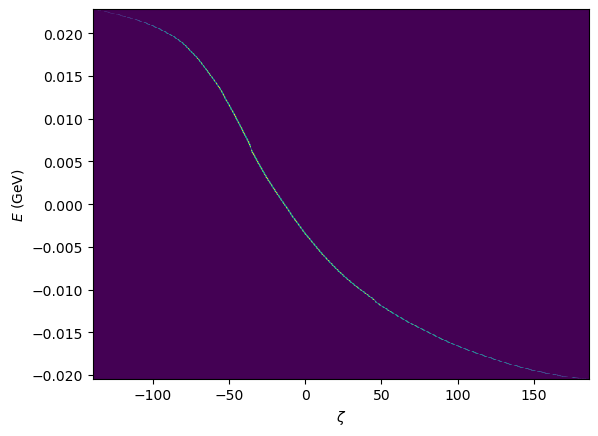

In [42]:
plt.hist2d( 1e6*testCSR.beam.z,  (testCSR.beam.energy - testCSR.beam.energy.mean() )/1e9, 500);
plt.xlabel(r'$\zeta$'); plt.ylabel('$E$ (GeV)');

### Run through B1LE

In [27]:
%%time
B1LE0= CSR2D(input_file= init_config);
B1LE0.CSR_params.apply_CSR = 0;
B1LE0.CSR_params.compute_CSR = 0;
B1LE0.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 183 ms, sys: 13.3 ms, total: 196 ms
Wall time: 283 ms


In [28]:
B1LE0.run();

Starting the DFCSR run
SBend(L=0.2, P0C=10017424405.383165, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 1, s = 0.2,  in 0.227006196975708 seconds
SBend(L=0.2, P0C=10017424405.383165, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 2, s = 0.4,  in 0.20966315269470215 seconds
SBend(L=0.2, P0C=10017424405.383165, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 3, s = 0.6000000000000001,  in 0.21312475204467773 seconds
SBend(L=0.2, P0C=10017424405.383165, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 4, s = 0.8, 

In [14]:
i = 0;

In [15]:
#Change config
name = '';
for file in os.listdir(output_dir):
    if file.endswith('-particles-end.h5') and file.startswith(lattice_names[i]):
        name = file;
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i + 1}: {lattice_names[i+1]}")
print(f"Using {name} as next input for {lattice_names[i+1]}")
i += 1;
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 0: b1le_0, moving onto 1: b1le_1
Using b1le_0_1M_-17.0_-41.5-particles-end.h5 as next input for b1le_1
Done


In [ ]:
### Run Up to B2LE Entrance

In [17]:
%%time
B1LE1= CSR2D(input_file= curr_config);
# Turn off CSR
B1LE1.CSR_params.apply_CSR = 0;
B1LE1.CSR_params.compute_CSR = 0;
B1LE1.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 175 ms, sys: 19.2 ms, total: 194 ms
Wall time: 228 ms


In [18]:
B1LE1.run();

Starting the DFCSR run
Finish step 1, s = 0.0425209036,  in 0.09952521324157715 seconds
Finish step 2, s = 0.0850418072,  in 0.08930754661560059 seconds
Finish step 3, s = 0.1275627108,  in 0.08860206604003906 seconds
Finish step 4, s = 0.1700836144,  in 0.08900141716003418 seconds
Finish step 5, s = 0.212604518,  in 0.09086084365844727 seconds
Finish step 6, s = 0.2551254216,  in 0.08899521827697754 seconds
Finish step 7, s = 0.2976463252,  in 0.09366059303283691 seconds
Finish step 8, s = 0.3401672288,  in 0.0884408950805664 seconds
Finish step 9, s = 0.3826881324,  in 0.0903923511505127 seconds
Finish step 10, s = 0.425209036,  in 0.09411883354187012 seconds
Finish step 11, s = 0.4677299396,  in 0.0965886116027832 seconds
Finish step 12, s = 0.5102508432,  in 0.09905123710632324 seconds
Finish step 13, s = 0.5527717468000001,  in 0.09720993041992188 seconds
Finish step 14, s = 0.5952926504000001,  in 0.09765791893005371 seconds
Finish step 15, s = 0.6378135540000002,  in 0.099084138

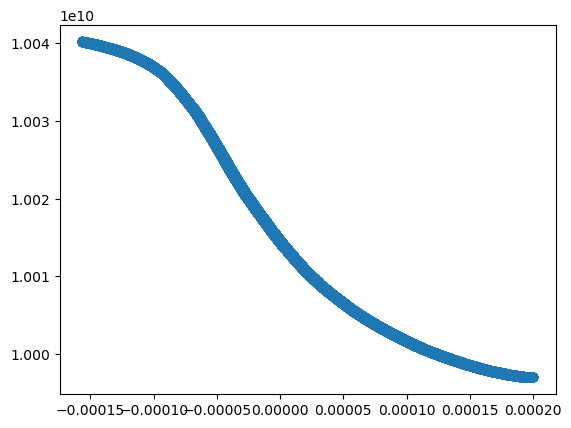

In [38]:
import pmd_beamphysics as pmd

m_dir = r'/global/cfs/cdirs/m669/obed/w_chicane_pydf_outputs/';

out_beam = pmd.ParticleGroup( m_dir + 'bc20_-17.0_-41.5-2024-08-20T20_17_45-07_00-particles-end.h5');

plt.scatter(out_beam.z, out_beam.pz)

In [33]:
with h5py.File(m_dir+'bc20_-17.0_-41.5-2024-08-20T20_17_45-07_00-particles-end.h5','r') as beam:
    print(beam.keys() )

<KeysViewHDF5 ['momentum', 'particleStatus', 'position', 'time', 'weight']>


In [19]:
#Change config
name = '';
for file in os.listdir(output_dir):
    if file.endswith('-particles-end.h5') and file.startswith(lattice_names[i]):
        name = file;
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i + 1}: {lattice_names[i+1]}")
print(f"Using {name} as next input for {lattice_names[i+1]}")
i += 1;
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 1: b1le_1, moving onto 2: b2le_0
Using b1le_1_1M_-17.0_-41.5-particles-end.h5 as next input for b2le_0
Done


In [ ]:
### Run through B2LE

In [22]:
%%time
B2LE0= CSR2D(input_file= curr_config);
# Turn on CSR
B2LE0.CSR_params.apply_CSR = 1;
B2LE0.CSR_params.compute_CSR = 1;
B2LE0.CSR_params.transverse_on = 1;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 172 ms, sys: 8 ms, total: 180 ms
Wall time: 237 ms


In [ ]:
B2LE0.run();

Starting the DFCSR run
Existing file /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b2le_0_1M_-17.0_-41.5-wakes.h5 deleted.
Wakes written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b2le_0_1M_-17.0_-41.5-wakes.h5
Finish step 1, s = 0.072996,  in 3.4053213596343994 seconds
Finish step 2, s = 0.145992,  in 3.499500036239624 seconds
Finish step 3, s = 0.21898800000000002,  in 3.456598997116089 seconds
Finish step 4, s = 0.291984,  in 3.4107513427734375 seconds
Finish step 5, s = 0.36498,  in 3.4920902252197266 seconds
Finish step 6, s = 0.43797600000000003,  in 3.4349024295806885 seconds
Finish step 7, s = 0.510972,  in 3.5240440368652344 seconds
Finish step 8, s = 0.583968,  in 3.4443368911743164 seconds
Finish step 9, s = 0.6569640000000001,  in 3.509833574295044 seconds
Finish step 10, s = 0.7299600000000002,  in 3.5032448768615723 seconds
Finish step 11, s = 0.8029560000000002,  in 3.437070608139038 seconds
Finish step 12, s = 0.8759520000000003,  in 3.50649

In [8]:
i = 2

In [9]:
name = '';
for file in os.listdir(output_dir):
    if file.endswith('-particles-end.h5') and file.startswith(lattice_names[i]):
        name = file;
name

#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 2: b2le_0, moving onto 3: b2le_1
Done


In [ ]:
### Run Up to B3LE Entrance

In [10]:
%%time
B2LE1= CSR2D(input_file= curr_config);
# Turn on CSR
B2LE1.CSR_params.apply_CSR = 0;
B2LE1.CSR_params.compute_CSR = 0;
B2LE1.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 177 ms, sys: 14.5 ms, total: 192 ms
Wall time: 320 ms


In [11]:
B2LE1.run();

Starting the DFCSR run
Finish step 1, s = 0.072996,  in 0.10456228256225586 seconds
Finish step 2, s = 0.145992,  in 0.10644292831420898 seconds
Finish step 3, s = 0.21898800000000002,  in 0.2537205219268799 seconds
Finish step 4, s = 0.291984,  in 0.24066472053527832 seconds
Finish step 5, s = 0.36498,  in 0.24622750282287598 seconds
Finish step 6, s = 0.43797600000000003,  in 0.22839927673339844 seconds
Finish step 7, s = 0.510972,  in 0.23598170280456543 seconds
Finish step 8, s = 0.583968,  in 0.2336101531982422 seconds
Finish step 9, s = 0.6569640000000001,  in 0.23906803131103516 seconds
Finish step 10, s = 0.7299600000000002,  in 0.24950647354125977 seconds
Finish step 11, s = 0.8029560000000002,  in 0.25370097160339355 seconds
Finish step 12, s = 0.8759520000000003,  in 0.2401890754699707 seconds
Finish step 13, s = 0.9489480000000001,  in 0.09733915328979492 seconds
Finish step 14, s = 1.0219440000000002,  in 0.09301877021789551 seconds
Finish step 15, s = 1.0949400000000002, 

In [12]:
name = '';
for file in os.listdir(output_dir):
    if file.endswith('-particles-end.h5') and file.startswith(lattice_names[i]):
        name = file;
name

#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 3: b2le_1, moving onto 4: b3le_0
Done


In [ ]:
### Run Through B3LE

In [13]:
%%time
B3LE0= CSR2D(input_file= curr_config);
# Turn on CSR
B3LE0.CSR_params.apply_CSR = 1;
B3LE0.CSR_params.compute_CSR = 1;
B3LE0.CSR_params.transverse_on = 1;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 175 ms, sys: 8.3 ms, total: 183 ms
Wall time: 236 ms


In [14]:
B3LE0.run();

Starting the DFCSR run
Wakes written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b3le_0_1M_-17.0_-41.5-wakes.h5
Finish step 1, s = 0.021148,  in 3.411992311477661 seconds
Finish step 2, s = 0.042296,  in 3.3856029510498047 seconds
Finish step 3, s = 0.063444,  in 3.4038290977478027 seconds
Finish step 4, s = 0.084592,  in 3.454688787460327 seconds
Finish step 5, s = 0.10574,  in 3.4763119220733643 seconds
Finish step 6, s = 0.126888,  in 3.4186882972717285 seconds
Finish step 7, s = 0.148036,  in 3.3621246814727783 seconds
Finish step 8, s = 0.169184,  in 3.4026474952697754 seconds
Finish step 9, s = 0.190332,  in 3.5136401653289795 seconds
Finish step 10, s = 0.21148,  in 3.4487667083740234 seconds
Finish step 11, s = 0.232628,  in 3.546565294265747 seconds
Finish step 12, s = 0.253776,  in 3.571028470993042 seconds
Finish step 13, s = 0.274924,  in 3.5073342323303223 seconds
Finish step 14, s = 0.296072,  in 3.5310587882995605 seconds
Finish step 15, s = 0.31722,  in

In [15]:
name = '';
for file in os.listdir(output_dir):
    if file.endswith('-particles-end.h5') and file.startswith(lattice_names[i]):
        name = file;
name

#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 4: b3le_0, moving onto 5: b3le_1
Done


In [16]:
### Run Up to B3RE Entrance
B3LE1= CSR2D(input_file= curr_config);
B3LE1.CSR_params.apply_CSR = 0;
B3LE1.CSR_params.compute_CSR = 0;
B3LE1.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500


In [17]:
%%time
B3LE1.run();

Starting the DFCSR run
Finish step 1, s = 0.0395,  in 0.09550738334655762 seconds
Finish step 2, s = 0.079,  in 0.0967552661895752 seconds
Finish step 3, s = 0.1185,  in 0.09412240982055664 seconds
Finish step 4, s = 0.158,  in 0.09772276878356934 seconds
Finish step 5, s = 0.1975,  in 0.09440422058105469 seconds
Finish step 6, s = 0.23700000000000002,  in 0.09345221519470215 seconds
Beam at position 0.23700000000000002 is written to /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b3le_1_1M_-17.0_-41.5-particles-end.h5
Statistics written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b3le_1_1M_-17.0_-41.5-statistics.h5
CPU times: user 973 ms, sys: 32.1 ms, total: 1 s
Wall time: 1.26 s


In [18]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 5: b3le_1, moving onto 6: b3re_0
Using b3le_0_1M_-17.0_-41.5-particles-end.h5 as input
Done


In [19]:
### Run Through B3RE
B3RE0= CSR2D(input_file= curr_config);
B3RE0.CSR_params.apply_CSR = 1;
B3RE0.CSR_params.compute_CSR = 1;
B3RE0.CSR_params.transverse_on = 1;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500


In [20]:
%%time
B3RE0.run();

Starting the DFCSR run
Wakes written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b3re_0_1M_-17.0_-41.5-wakes.h5
Finish step 1, s = 0.0395,  in 2.637563467025757 seconds
Finish step 2, s = 0.079,  in 2.6517341136932373 seconds
Finish step 3, s = 0.1185,  in 2.605790853500366 seconds
Finish step 4, s = 0.158,  in 2.6406524181365967 seconds
Finish step 5, s = 0.1975,  in 2.6500401496887207 seconds
Finish step 6, s = 0.23700000000000002,  in 2.7018964290618896 seconds
Finish step 7, s = 0.2765,  in 2.7749288082122803 seconds
Finish step 8, s = 0.316,  in 2.695694923400879 seconds
Finish step 9, s = 0.3555,  in 2.6936967372894287 seconds
Finish step 10, s = 0.39499999999999996,  in 2.6293134689331055 seconds
Finish step 11, s = 0.43449999999999994,  in 2.685293197631836 seconds
Finish step 12, s = 0.4739999999999999,  in 2.67834734916687 seconds
Finish step 13, s = 0.5135,  in 2.581096649169922 seconds
Finish step 14, s = 0.553,  in 2.4675281047821045 seconds
Finish step 15

In [21]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 6: b3re_0, moving onto 7: b3re_1
Using b3le_0_1M_-17.0_-41.5-particles-end.h5 as input
Done


In [22]:
### Run Up to B2RE Entrance

In [23]:
B3RE1= CSR2D(input_file= curr_config);

start reinterpolation. number of slice 1
xbins = 500  zbins =  500


In [24]:
# Turn off CSR

In [25]:
B3RE1.CSR_params.apply_CSR = 0;
B3RE1.CSR_params.compute_CSR = 0;
B3RE1.CSR_params.transverse_on = 0;

In [26]:
%%time
B3RE1.run();

Starting the DFCSR run
Finish step 1, s = 0.0395,  in 0.23990917205810547 seconds
Finish step 2, s = 0.079,  in 0.23066949844360352 seconds
Finish step 3, s = 0.1185,  in 0.22953128814697266 seconds
Finish step 4, s = 0.158,  in 0.09467935562133789 seconds
Finish step 5, s = 0.1975,  in 0.08990263938903809 seconds
Finish step 6, s = 0.23700000000000002,  in 0.08796119689941406 seconds
Finish step 7, s = 0.2765,  in 0.09129476547241211 seconds
Finish step 8, s = 0.316,  in 0.0908660888671875 seconds
Finish step 9, s = 0.3555,  in 0.09089159965515137 seconds
Finish step 10, s = 0.39499999999999996,  in 0.08996701240539551 seconds
Finish step 11, s = 0.43449999999999994,  in 0.09083914756774902 seconds
Finish step 12, s = 0.4739999999999999,  in 0.09040045738220215 seconds
Finish step 13, s = 0.5135,  in 0.0919039249420166 seconds
Finish step 14, s = 0.5529999999999999,  in 0.09298253059387207 seconds
Finish step 15, s = 0.5924999999999999,  in 0.09282350540161133 seconds
Finish step 16, 

In [2]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

NameError: name 'i' is not defined

In [ ]:
### Run Through B2RE
B2RE0= CSR2D(input_file= curr_config);
# Turn on CSR
B3RE1.CSR_params.apply_CSR = 1;
B3RE1.CSR_params.compute_CSR = 1;
B3RE1.CSR_params.transverse_on = 1;

In [ ]:
%%time
B2RE0.run();

Starting the DFCSR run
Wakes written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b2re_0_1M_-17.0_-41.5-wakes.h5
Finish step 1, s = 0.072996,  in 2.6924593448638916 seconds
Finish step 2, s = 0.145992,  in 2.647350549697876 seconds
Finish step 3, s = 0.21898800000000002,  in 2.608074188232422 seconds
Finish step 4, s = 0.291984,  in 2.607999086380005 seconds
Finish step 5, s = 0.36498,  in 2.6360890865325928 seconds
Finish step 6, s = 0.43797600000000003,  in 2.619907855987549 seconds
Finish step 7, s = 0.510972,  in 2.637097120285034 seconds
Finish step 8, s = 0.583968,  in 2.589387893676758 seconds
Finish step 9, s = 0.6569640000000001,  in 2.922868013381958 seconds
Finish step 10, s = 0.7299600000000002,  in 2.6665120124816895 seconds
Finish step 11, s = 0.8029560000000002,  in 3.177131175994873 seconds
start reinterpolation. number of slice 13
xbins = 1208  zbins =  502
Finish step 12, s = 0.8759520000000003,  in 4.5657734870910645 seconds
Finish step 13, s = 0.9489

In [32]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 8: b2re_0, moving onto 9: b2re_1
Using b3le_0_1M_-17.0_-41.5-particles-end.h5 as input
Done


In [33]:
### Run Up to B1RE Start

In [34]:
%%time
B2RE1= CSR2D(input_file= curr_config);
# Turn off CSR
B2RE1.CSR_params.apply_CSR = 0;
B2RE1.CSR_params.compute_CSR = 0;
B2RE1.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 168 ms, sys: 4.04 ms, total: 172 ms
Wall time: 395 ms


In [35]:
B2RE1.run();

Starting the DFCSR run
Finish step 1, s = 0.072996,  in 0.09316229820251465 seconds
Finish step 2, s = 0.145992,  in 0.09170746803283691 seconds
Finish step 3, s = 0.21898800000000002,  in 0.08875775337219238 seconds
Finish step 4, s = 0.291984,  in 0.08774495124816895 seconds
Finish step 5, s = 0.36498,  in 0.0891721248626709 seconds
Finish step 6, s = 0.43797600000000003,  in 0.08921694755554199 seconds
Finish step 7, s = 0.510972,  in 0.09100151062011719 seconds
Finish step 8, s = 0.583968,  in 0.09322881698608398 seconds
Finish step 9, s = 0.6569640000000001,  in 0.09107780456542969 seconds
Finish step 10, s = 0.7299600000000002,  in 0.09028244018554688 seconds
Finish step 11, s = 0.8029560000000002,  in 0.08985495567321777 seconds
Finish step 12, s = 0.8759520000000003,  in 0.08859443664550781 seconds
Finish step 13, s = 0.9489480000000003,  in 0.08981037139892578 seconds
Finish step 14, s = 1.0219440000000004,  in 0.08974170684814453 seconds
Finish step 15, s = 1.0949400000000005

In [37]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name);
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

Just finished lattice 9: b2re_1, moving onto 10: b1re_0
Using b3le_0_1M_-17.0_-41.5-particles-end.h5 as input
Done


In [38]:
### Run Through B1RE

In [40]:
%%time
B1RE0= CSR2D(input_file= curr_config);
# Turn off CSR
B1RE0.CSR_params.apply_CSR = 1;
B1RE0.CSR_params.compute_CSR = 1;
B1RE0.CSR_params.transverse_on = 1;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500
CPU times: user 157 ms, sys: 11.9 ms, total: 169 ms
Wall time: 286 ms


In [41]:
%%time
B1RE0.run();

Starting the DFCSR run
Wakes written to  /global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b1re_0_1M_-17.0_-41.5-wakes.h5
Finish step 1, s = 0.0425209036,  in 2.682424306869507 seconds
Finish step 2, s = 0.0850418072,  in 2.537076950073242 seconds
Finish step 3, s = 0.1275627108,  in 2.726689338684082 seconds
Finish step 4, s = 0.1700836144,  in 2.642847776412964 seconds
Finish step 5, s = 0.212604518,  in 2.6446151733398438 seconds
Finish step 6, s = 0.2551254216,  in 2.7449522018432617 seconds
Finish step 7, s = 0.2976463252,  in 2.9212646484375 seconds
Finish step 8, s = 0.3401672288,  in 2.58393931388855 seconds
Finish step 9, s = 0.3826881324,  in 2.5833969116210938 seconds
Finish step 10, s = 0.425209036,  in 2.604198694229126 seconds
Finish step 11, s = 0.4677299396,  in 2.654926300048828 seconds
Finish step 12, s = 0.5102508432,  in 2.5637035369873047 seconds
Finish step 13, s = 0.5527717468000001,  in 2.6012473106384277 seconds
Finish step 14, s = 0.5952926504000001,  i

In [ ]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name');
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

In [42]:
# Examine beam

In [78]:
endbc20 = r'/global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/b1le_0_1M_-17.0_-41.5-particles-end.h5'; 

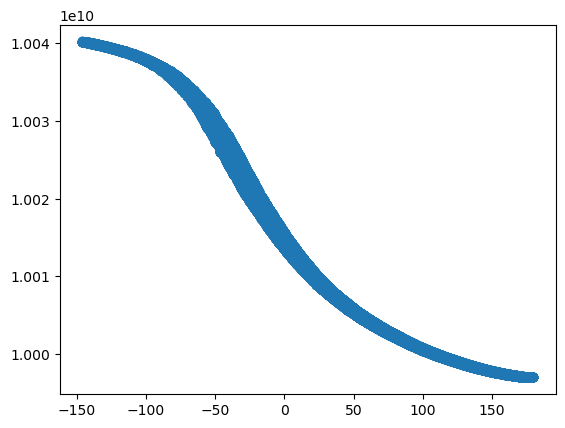

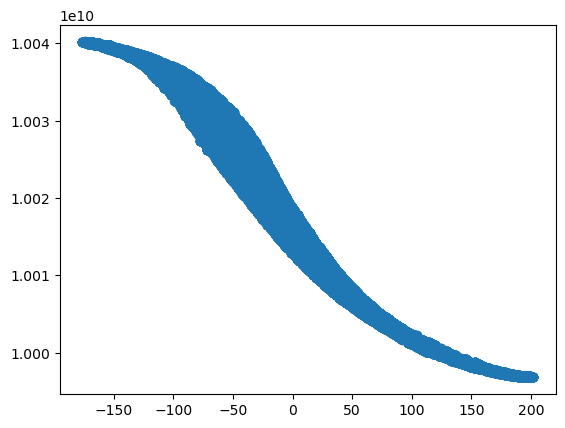

[7.09192063e-09 7.09187664e-09 7.09156994e-09 ... 7.09188957e-09
 7.09145359e-09 7.09165563e-09]


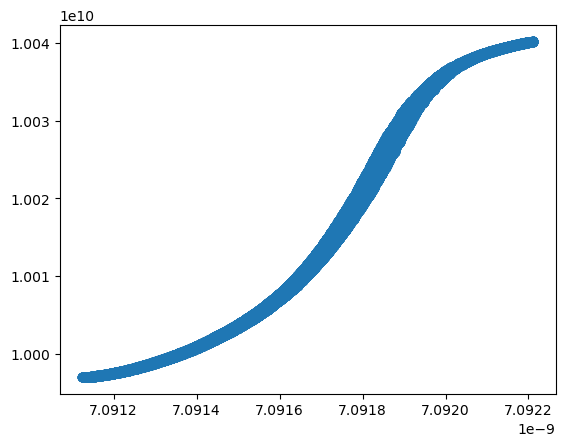

In [ ]:
### Run through FF

In [ ]:
%%time
FF= CSR2D(input_file= curr_config);
# Turn off CSR
FF.CSR_params.apply_CSR = 0;
FF.CSR_params.compute_CSR = 0;
FF.CSR_params.transverse_on = 0;

In [ ]:
FF.run();

In [ ]:
#Change config
print(f"Just finished lattice {i}: {lattice_names[i]}, moving onto {i+1}: {lattice_names[i+1]}")
i += 1;
print(f"Using {name} as input")
### Go to config, change input beam, lattice, and writename
# Replace the beam file
replace_config_content(init_config, 'style:', 'ParticleGroup');
replace_config_content(init_config, 'ParticleGroup_h5:', output_dir + name');
# Replace lattice with next in the list
replace_config_content(init_config, 'lattice_input_file:', 'lattice_files/' + lattice_names[i] + '.yaml');
# Replace output write name
replace_config_content(init_config, 'write_name:', '\'' + lattice_names[i] + '_1M_' + phi1 + '_' + phi2 + '\'');
curr_config = init_config;
print('Done')

In [ ]:
### Run up to IP

In [ ]:
%%time
IP= CSR2D(input_file= curr_config);
# Turn off CSR
IP.CSR_params.apply_CSR = 0;
IP.CSR_params.compute_CSR = 0;
IP.CSR_params.transverse_on = 0;

In [ ]:
%%time
IP.run();

In [ ]:
beams = [];
for name in lattice_names:
    for file in os.listdir(input_dir):
        if file.startswith(name):
            with h5py.File(input_dir + file, 'r') as beam:
                D = {};
                for key in beam.keys():
                    try:
                        D[key] = beam[key][:];
                    except:
                        D[key] = beam[key][()];
            beams.append(D)

In [ ]:
m = len(beams)
fig, ax = plt.subplots(m, figsize = (6, 48)  )
for i in range(m):
    ax[i].scatter(1e6 * beams[i]['zeta'], beams[i]['delta'], s = .1)
